<a href="https://colab.research.google.com/github/soerenml/tensorflow-certificate/blob/master/Time_series_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sunspots demo

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.3.0


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-24 16:46:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-24 16:46:22 (115 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



<class 'list'>


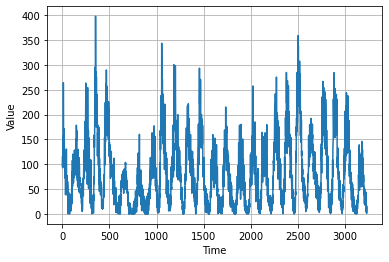

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Create two lists.
time_step = []
sunspots = []

"""
It makes sense to start with a list and convert the list to a
numpy array. Append values to an array is computationally intensive
while lists can do this very efficiently. Once process is completed,
running commputations with arrays is more efficient.
"""
with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # jump to the next input line.
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

# We convert our lists to numpy arrays due to computational efficiency
series = np.array(sunspots)
time = np.array(time_step)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plot_series(time,series)

In [ ]:
# Create training and validation set
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# Define input pipeline for training
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# Define input pipeline for prediction
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size,
                             shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 279ms/step - loss: 82.7785 - mae: 83.2667
Epoch 2/100
12/12 [==============================] - 3s 276ms/step - loss: 82.7785 - mae: 83.2667
Epoch 3/100
12/12 [==============================] - 3s 278ms/step - loss: 82.7784 - mae: 83.2667
Epoch 4/100
12/12 [==============================] - 3s 277ms/step - loss: 82.7784 - mae: 83.2666
Epoch 5/100
12/12 [==============================] - 3s 285ms/step - loss: 82.7784 - mae: 83.2666
Epoch 6/100
12/12 [==============================] - 3s 282ms/step - loss: 82.7784 - mae: 83.2666
Epoch 7/100
12/12 [==============================] - 3s 274ms/step - loss: 82.7784 - mae: 83.2666
Epoch 8/100
12/12 [==============================] - 3s 278ms/step - loss: 82.7783 - mae: 83.2665
Epoch 9/100
12/12 [==============================] - 3s 281ms/step - loss: 82.7783 - mae: 83.2665
Epoch 10/100
12/

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])